# Responsible Data Science Spring 2021: Homework 1


This notebook contains sample code; other methods at arriving at the correct answer were also accepted.

In [2]:
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.12.0
import matplotlib.pyplot as plt 

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult


from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn.preprocessing import MinMaxScaler
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

%matplotlib inline

     |████████████████████████████████| 174kB 5.6MB/s 
     |████████████████████████████████| 2.6MB 5.9MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394769 sha256=97e99d3586f2ad04d817eaad5fefff09c1f0d398f05bf9936866c0d9dcbf0c15
  Stored in directory: /root/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
Successfully built BlackBoxAuditing
ERROR: Could not find a version that satisfies the requirement tensorflow==1.12.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4

pip install 'aif360[LFR]'


# Problem 2
### **Load and split data into train, validation and test sets** 

### Read in the data

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2021-03-04 16:05:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  7.41MB/s    in 0.5s    

2021-03-04 16:05:48 (7.41 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2021-03-04 16:05:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M  4.23MB/s    in 0.5s    

2021

In [4]:
!cp adult.data /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.test /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.names /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/

# Problem 2, Part (a) 
### **Train a baseline Logistic Regression (LR) & Random Forest (RF) model and report metrics**

In [5]:
#Define privileged:'sex'=male(1) and unprivileged groups:'sex'=female(0):
#select a protected attribute of income-per-year
single_protected = ['sex']
single_privileged = [['Male']]
ad = AdultDataset(protected_attribute_names=single_protected,
privileged_classes=single_privileged, features_to_drop=['race',"age"])
print(ad.feature_names)
print(ad.label_names)
#split the original data to test and training group
ad_train, ad_test = ad.split([0.8], shuffle=True)

# Split training data in to training and validation data for hyperparameter tuning
ad_train, ad_val = ad_train.split([0.875], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
ad

['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleaners', 

               instance weights  features  ...                           labels
                                           ...                                 
                                   fnlwgt  ... native-country=Yugoslavia       
instance names                             ...                                 
0                           1.0  226802.0  ...                       0.0    0.0
1                           1.0   89814.0  ...                       0.0    0.0
2                           1.0  336951.0  ...                       0.0    1.0
3                           1.0  160323.0  ...                       0.0    1.0
5                           1.0  198693.0  ...                       0.0    0.0
...                         ...       ...  ...                       ...    ...
48837                       1.0  257302.0  ...                       0.0    0.0
48838                       1.0  154374.0  ...                       0.0    1.0
48839                       1.0  151910.

In [6]:
#print out the shape of the data to make sure the split is correct
#train:70% validate:10% Test:20%
print("Original one hot encoded Adult dataset shape: ",ad.features.shape)
print("Train dataset shape: ",ad_train.features.shape)
print("Test dataset shape: ", ad_test.features.shape)
print("validate dataset shape: ", ad_val.features.shape)

Original one hot encoded Adult dataset shape:  (45222, 97)
Train dataset shape:  (31654, 97)
Test dataset shape:  (9045, 97)
validate dataset shape:  (4523, 97)


In [7]:
#Use MinMaxScaler to fit the test data and train data
scaler = MinMaxScaler()
ad_train.features=scaler.fit_transform(ad_train.features)
ad_test.features=scaler.transform(ad_test.features)
ad_val.features=scaler.transform(ad_val.features)

In [8]:
#convert to dataframe
df,_= ad.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (45222, 98)
Index(['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov',
       'workclass=Private', 'workclass=Self-emp-inc',
       'workclass=Self-emp-not-inc', 'workclass=State-gov',
       'workclass=Without-pay', 'education=10th', 'education=11th',
       'education=12th', 'education=1st-4th', 'education=5th-6th',
       'education=7th-8th', 'education=9th', 'education=Assoc-acdm',
       'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate',
       'education=HS-grad', 'education=Masters', 'education=Preschool',
       'education=Prof-school', 'education=Some-college',
       'marital-status=Divorced', 'marital-status=Married-AF-spouse',
       'marital-status=Married-civ-spouse',
       'marital-status=Married-spouse-absent', 'marital-status=Never-married',
       'marital-status=Separated', 'marital-status=Widowed',
       'occupation=Adm-clerical', 'occupation=Armed-Forc

,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay,education=10th,education=11th,education=12th,education=1st-4th,education=5th-6th,education=7th-8th,education=9th,education=Assoc-acdm,education=Assoc-voc,education=Bachelors,education=Doctorate,education=HS-grad,education=Masters,education=Preschool,education=Prof-school,education=Some-college,marital-status=Divorced,marital-status=Married-AF-spouse,marital-status=Married-civ-spouse,marital-status=Married-spouse-absent,marital-status=Never-married,marital-status=Separated,marital-status=Widowed,occupation=Adm-clerical,occupation=Armed-Forces,occupation=Craft-repair,occupation=Exec-managerial,...,native-country=China,native-country=Columbia,native-country=Cuba,native-country=Dominican-Republic,native-country=Ecuador,native-country=El-Salvador,native-country=England,native-country=France,native-country=Germany,native-country=Greece,native-country=Guatemala,native-country=Haiti,native-country=Holand-Netherlands,native-country=Honduras,native-country=Hong,native-country=Hungary,native-country=India,native-country=Iran,native-country=Ireland,native-country=Italy,native-country=Jamaica,native-country=Japan,native-country=Laos,native-country=Mexico,native-country=Nicaragua,native-country=Outlying-US(Guam-USVI-etc),native-country=Peru,native-country=Philippines,native-country=Poland,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,226802.0,7.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,89814.0,9.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,336951.0,12.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,160323.0,10.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,198693.0,6.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
df_test,_= ad_test.convert_to_dataframe()
df_train,_= ad_train.convert_to_dataframe()
df_val,_=ad_val.convert_to_dataframe()

#seperate feasures and outcome
x_train= df_train.drop("income-per-year", axis=1)
y_train = df_train["income-per-year"]
print("Outcomes: ")
y_train.value_counts()

Outcomes: 


0.0    23815
1.0     7839
Name: income-per-year, dtype: int64

In [10]:
#fit the model
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)


In [11]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values
    y_pred = model.predict_proba(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # Since we're doing binary classification, all we need to know is the probability that the outcome = 1 (income-per-year)
    y_pred = [row[1] for row in y_pred] # This pulls the predicted probability that y = 1 for each observation

    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc

In [12]:
# Before we call the function, we need to set up the test data properly, the way we did for the training data.
x_test_o = df_test.drop("income-per-year", axis=1)
y_test_o = df_test["income-per-year"]

In [13]:
#calculate the overall accuracy
accuracy, auc = evaluate(initial_lr, x_test_o, y_test_o)
print("Overall Accuracy: ", accuracy)
print("AUC: ", auc)

Overall Accuracy:  0.8449972360420122
AUC:  0.900440760169744


In [14]:
#calculate the accuarcy for privileged group
#seperate the privileged group
df_train_privileged=df_train[df_train["sex"]==1.0]
#create variables
x_df_train_privileged=df_train_privileged.drop("income-per-year", axis=1)
y_df_train_privileged=df_train_privileged["income-per-year"]

print("Outcomes for privileged group: ")
print(y_df_train_privileged.value_counts())

#fit the model
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_df_train_privileged, y_df_train_privileged, sample_weight=None)

Outcomes for privileged group: 
0.0    14688
1.0     6688
Name: income-per-year, dtype: int64


In [15]:
# Before we call the function, we need to set up the test data properly, the way we did for the training data.
df_test_privileged=df_test[df_test["sex"]==1.0]
x_test_p = df_test_privileged.drop("income-per-year", axis=1)
y_test_p = df_test_privileged["income-per-year"]
#calculate the privileged group accuracy
accuracy_p, auc_p = evaluate(initial_lr, x_test_p, y_test_p)
print("Privileged group Accuracy: ", accuracy_p)
print("AUC: ", auc_p)

Privileged group Accuracy:  0.809833930315858
AUC:  0.8753584462982273


In [16]:
# the accuracy for unprivileged group
#seperate the privileged group
df_train_unprivileged=df_train[df_train["sex"]==0.0]

#create variables
x_df_train_unprivileged=df_train_unprivileged.drop("income-per-year", axis=1)
y_df_train_unprivileged=df_train_unprivileged["income-per-year"]

print("Outcomes for unprivileged group: ")
print(y_df_train_unprivileged.value_counts())

#fit the model
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_df_train_unprivileged, y_df_train_unprivileged, sample_weight=None)


Outcomes for unprivileged group: 
0.0    9127
1.0    1151
Name: income-per-year, dtype: int64


In [17]:
# Before we call the function, we need to set up the test data properly, the way we did for the training data.
df_test_unprivileged=df_test[df_test["sex"]==0.0]
x_test_up = df_test_unprivileged.drop("income-per-year", axis=1)
y_test_up = df_test_unprivileged["income-per-year"]

#calculate the unprivileged group accuracy
accuracy_up, auc_up = evaluate(initial_lr, x_test_up, y_test_up)
print("Unprivileged group Accuracy: ", accuracy_up)
print("AUC: ", auc_up)

Unprivileged group Accuracy:  0.9221495005167069
AUC:  0.9294695886894653


In [18]:
#evaluate bias on the testing data
#copy our data to aif 360 to analysize the fairness matrics
# Copy the dataset
test_preds_df = df_test.copy()
# Calculate predicted values
test_preds_df['income-per-year'] = initial_lr.predict(x_test_o)

In [19]:
#create an object of the aif360 StandardDataset
orig_aif360 = StandardDataset(df_test, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
preds_aif360 = StandardDataset(test_preds_df, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])

In [20]:
metric_dataset_transf_preds = BinaryLabelDatasetMetric(
    preds_aif360, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )
print("The disparate impact is",metric_dataset_transf_preds.disparate_impact())


The disparate impact is 0.34790108344405624


In [21]:
#calculate the false postive rate difference
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
print("\nFalse positive rate for privledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
FP_p=orig_vs_preds_metrics.false_positive_rate(privileged=True)
FP_up=orig_vs_preds_metrics.false_positive_rate(privileged=False)
print("False positive rate difference= ",abs(FP_p-FP_up))


False positive rate for privledged groups = 0.073390
False positive rate for unprivledged groups = 0.019186
False positive rate difference=  0.05420456028570751


In [22]:
#Overall Accuracy for random forest model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test_o)
from sklearn import metrics
print("Overall Accuracy using RF:",metrics.accuracy_score(y_test_o, y_pred))

Overall Accuracy using RF: 0.8297401879491432


In [23]:
#privileged group accuracy using random forest model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_df_train_privileged,y_df_train_privileged)
y_pred_p=clf.predict(x_test_p)
from sklearn import metrics
print("Privileged group Accuracy using RF:",metrics.accuracy_score(y_test_p, y_pred_p))

Privileged group Accuracy using RF: 0.7914360143275806


In [24]:
#Unprevileged group accuracy using RF model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_df_train_unprivileged,y_df_train_unprivileged)
y_pred_up=clf.predict(x_test_up)
from sklearn import metrics
print("Unprevileged Grop Accuracy using RF:",metrics.accuracy_score(y_test_up, y_pred_up))

Unprevileged Grop Accuracy using RF: 0.9114708921805029


In [25]:
##Evaluate bias on the testing data for random forest
#copy our data to aif 360 t0 analysize the fairness matrics
#Copy the dataset
test_preds_df_rf = df_test.copy()
# Calculate predicted values
test_preds_df_rf['income-per-year'] = clf.predict(x_test_o)

#create an object of the aif360 StandardDataset
orig_aif360 = StandardDataset(df_test, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
preds_aif360_rf = StandardDataset(test_preds_df_rf, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
#use BinaryLabelDatasetMetric
metric_dataset_transf_preds = BinaryLabelDatasetMetric(
    preds_aif360_rf, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )
print("The disparate impact is",metric_dataset_transf_preds.disparate_impact())

The disparate impact is 0.747732231025376


In [26]:
#calculate the false postive rate difference(random forest)
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360_rf,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
print("\nFalse positive rate for privledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
FP_p=orig_vs_preds_metrics.false_positive_rate(privileged=True)
FP_up=orig_vs_preds_metrics.false_positive_rate(privileged=False)
print("False positive rate difference= ",abs(FP_p-FP_up))


False positive rate for privledged groups = 0.021307
False positive rate for unprivledged groups = 0.033673
False positive rate difference=  0.012365852139246816


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline LR and RF models**

In [27]:
# function for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [28]:
#learn from the similar function used in Lab3
#define the fuction for logistic regression
def tune_logistic_regression(df_train, df_val, penalty_types, C_values, weights=None, verbose=True):
    # define the variable which can be used in the function
    x_train = df_train.drop("income-per-year", axis=1)
    y_train = df_train["income-per-year"]
    x_val = df_val.drop("income-per-year", axis=1)
    y_val = df_val["income-per-year"]

    #create list for storing the results
    parameters = []
    models = []
    aucs_result = []  
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            #established the model and fiting it with our training data
            model_LR = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
            model_LR = model_LR.fit(x_train, y_train, sample_weight=weights)
            
            #calculate accurracy
            accuracy, auc  = evaluate(model_LR, x_val, y_val)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(model_LR)
            aucs_result.append(auc)
            
            # Print the results
            #if verbose:
                #print("\nParmeters: \tpenalty={} \tC={}".format(penalty, C))
                #print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(aucs_result)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", aucs_result[best_model_index])
    
    # Return best model
    return best_model, parameters, models, aucs_result,best_model_index,parameters[best_model_index],aucs_result[best_model_index]


In [29]:
#define the fuction for random forest
def tune_random_forest(df_train, df_val, max_depth, n_estimators,weights=None, verbose=True):
    # define the variable which can be used in the function
    x_train = df_train.drop("income-per-year", axis=1)
    y_train = df_train["income-per-year"]
    x_val = df_val.drop("income-per-year", axis=1)
    y_val = df_val["income-per-year"]

    #create list for storing the results
    parameters = []
    models = []
    aucs_result = []  
    # Loop through the hyperparameters of interest
    for maxi in max_depth:
      for estimators in n_estimators:
            
            #established the random forest model and fiting it with our training data
            model_RF = RandomForestClassifier(n_estimators=100)
            model_RF = model_RF.fit(x_train, y_train, sample_weight=weights)
            
            #calculate accurracy
            accuracy, auc  = evaluate(model_RF, x_val, y_val)
            
            # Store the results
            parameters.append({'Max_depth': maxi,'n_estimator': estimators})
            models.append(model_RF)
            aucs_result.append(auc)
            
            # Print the results
            #if verbose:
                #print("\nParmeters: \tn_max_depth={} \tn_estimators={}".format(maxi,estimators))
                #print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(aucs_result)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", aucs_result[best_model_index])
    
    # Return best model
    return best_model, parameters, models, aucs_result,best_model_index,parameters[best_model_index],aucs_result[best_model_index]


In [30]:
#define the description matrice
def des_matrice(model,X, y_true):
  orig_pred=df_val.copy()
  orig_pred["income-per-year"]=model.predict(X)
  preds_aif360 = StandardDataset(orig_pred, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
  orig_aif360 = StandardDataset(df_val, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
  
  #classifiacation Metric
  orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
  #BinaryMetric
  metric_dataset_predict = BinaryLabelDatasetMetric(
    preds_aif360, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )
  #accuracy
  accuracy=orig_vs_preds_metrics.accuracy()

  #accuracy for p-group and un-group
  privileged_accuracy=orig_vs_preds_metrics.accuracy(privileged=True)
  unprivileged_accuracy=orig_vs_preds_metrics.accuracy(privileged=False)

  #disparate impact
  disparate_impact=metric_dataset_predict.disparate_impact()

  #false positive rate difference
  FP_p=orig_vs_preds_metrics.false_positive_rate(privileged=True)
  FP_up=orig_vs_preds_metrics.false_positive_rate(privileged=False)
  fp_rate_d=abs(FP_p-FP_up)

  return accuracy,privileged_accuracy,unprivileged_accuracy,disparate_impact,fp_rate_d



  

In [32]:
#Use for loop to test on 10 difference model
overall_accuracy_o=[]
privileged_accuracy_o=[]
unprivileged_accuracy_o=[]
disparate_impact_o=[]
false_positive_difference_o=[]

#create list to store the tuned result
overall_accuracy=[]
privileged_accuracy=[]
unprivileged_accuracy=[]
disparate_impact=[]
false_positive_difference=[]
best_model_list=[]
best_parameter_list=[]
model_auc=[] 
  

#start the for loop
for i in range (10):
  #splite the data
  single_protected = ['sex']
  single_privileged = [['Male']]
  ad = AdultDataset(protected_attribute_names=single_protected,
  privileged_classes=single_privileged, features_to_drop=['race',"age"])
  #split the original data to test and training group
  ad_train, ad_test = ad.split([0.8], shuffle=True)

  # Split training data in to training and validation data for hyperparameter tuning
  ad_train, ad_val = ad_train.split([0.875], shuffle=True)

  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]

  #Use MinMaxScaler to fit the test data and train data
  scaler = MinMaxScaler()
  ad_train.features=scaler.fit_transform(ad_train.features)
  ad_test.features=scaler.transform(ad_test.features)
  ad_val.features=scaler.transform(ad_val.features)
  #transpform the dataframe
  df,_= ad.convert_to_dataframe()
  df_test,_= ad_test.convert_to_dataframe()
  df_train,_= ad_train.convert_to_dataframe()
  df_val,_=ad_val.convert_to_dataframe()
  #seperate feasures and outcome
  x_train= df_train.drop("income-per-year", axis=1)
  y_train = df_train["income-per-year"]

  #use the original model
  # Set up the logistic regression model with the given hyperparameters
  initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
  # Fit the model using the training data
  initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)

  # Before we call the function, we need to set up the validate data properly, the way we did for the training data.
  x_val_10 = df_val.drop("income-per-year", axis=1)
  y_val_10 = df_val["income-per-year"]

  acc_or,p_acc_or,up_acc_or,dis_impact_or,fp_diff_or=des_matrice(initial_lr,x_val_10, y_val_10)

  overall_accuracy_o.append(acc_or)
  privileged_accuracy_o.append(p_acc_or)
  unprivileged_accuracy_o.append(up_acc_or)
  disparate_impact_o.append(dis_impact_or)
  false_positive_difference_o.append(fp_diff_or)
  

  
  #tuning using LR
  print("No. ",i+1 ,"sample's result")
  best_model, parameters, models, aucs_result,best_model_index,parameters[best_model_index],aucs_result[best_model_index]= tune_logistic_regression(df_train, df_val, penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000])
  #find out the best model

  best_model_list.append(best_model)
  best_parameter_list.append(parameters[best_model_index])
  model_auc.append(aucs_result[best_model_index])
  print("")



  #tuned data test using the best model
  # Fit the model using the training data
  best_model = best_model.fit(x_train, y_train, sample_weight=None)

  # Before we call the function, we need to set up the test data properly, the way we did for the training data.
  x_val_10_best = df_val.drop("income-per-year", axis=1)
  y_val_10_best = df_val["income-per-year"]

  acc,p_acc,up_acc,dis_impact,fp_diff=des_matrice(best_model,x_val_10_best, y_val_10_best)

  overall_accuracy.append(acc)
  privileged_accuracy.append(p_acc)
  unprivileged_accuracy.append(up_acc)
  disparate_impact.append(dis_impact)
  false_positive_difference.append(fp_diff)


best_auc_index=np.argmax(model_auc)
best_model_10_parameter=best_parameter_list[best_auc_index]
best_model_10=best_model_list[best_auc_index]

print("The most acurrate model after 10 tests: ")
print("Parameter: ",best_model_10_parameter)
print("AUC: ",model_auc[best_auc_index])


No.  1 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.8999164427652265



No.  2 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9041335196179487



No.  3 sample's result

Best model parameters:  {'penalty': 'l2', 'C': 100}
Best model AUC:  0.9087720680345657



No.  4 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9013543782388337



No.  5 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9054525449827635



No.  6 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.8964943224937197



No.  7 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9026137572643445



No.  8 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9045626179987414



No.  9 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.9028340467818378



No.  10 sample's result

Best model parameters:  {'penalty': 'l1', 'C': 1}
Best model AUC:  0.904098267620096

The most acurrate model after 10 tests: 
Parameter:  {'penalty': 'l2', 'C': 100}
AUC:  0.9087720680345657


In [34]:
#the best model to use in part c, the most accurate one among the ten test
#best_LR_for_c=best_model_10
#best_model_list

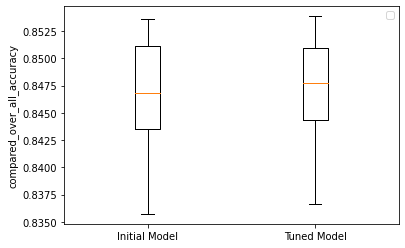

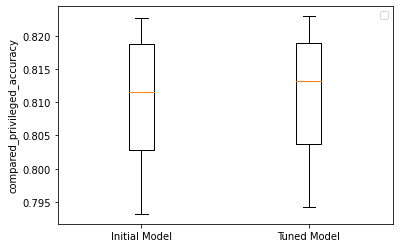

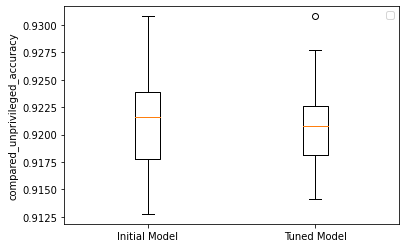

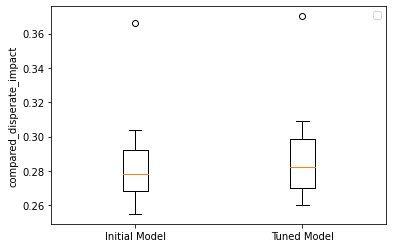

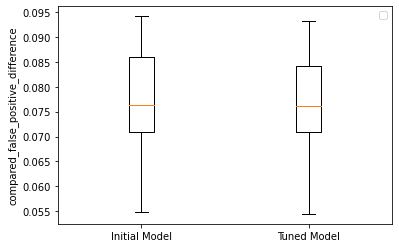

In [35]:
#Draw boxplot to understand the difference
init_metrics=[overall_accuracy_o,privileged_accuracy_o,unprivileged_accuracy_o,disparate_impact_o,false_positive_difference_o]
tuned_metrics=[overall_accuracy,privileged_accuracy,unprivileged_accuracy,disparate_impact,false_positive_difference]
#over all
metric_name="compared_over_all_accuracy"
plot_init_v_tuned_box(init_metrics[0], tuned_metrics[0], metric_name)

#privileged
metric_name="compared_privileged_accuracy"
plot_init_v_tuned_box(init_metrics[1], tuned_metrics[1], metric_name)

#unprivileged
metric_name="compared_unprivileged_accuracy"
plot_init_v_tuned_box(init_metrics[2], tuned_metrics[2], metric_name)

#disperate impact
metric_name="compared_disperate_impact"
plot_init_v_tuned_box(init_metrics[3], tuned_metrics[3], metric_name)

#false_positive rate difference
metric_name="compared_false_positive_difference"
plot_init_v_tuned_box(init_metrics[4], tuned_metrics[4], metric_name)



In [36]:
#Random Forest
#Use for loop to test on 10 difference model
overall_accuracy_o_rf=[]
privileged_accuracy_o_rf=[]
unprivileged_accuracy_o_rf=[]
disparate_impact_o_rf=[]
false_positive_difference_o_rf=[]

#create list to store the tuned result
overall_accuracy_rf=[]
privileged_accuracy_rf=[]
unprivileged_accuracy_rf=[]
disparate_impact_rf=[]
false_positive_difference_rf=[]
best_model_list_rf=[]
best_parameter_list_rf=[]
model_auc_rf=[] 
  

#start the for loop
for i in range (10):
  #splite the data
  single_protected = ['sex']
  single_privileged = [['Male']]
  ad = AdultDataset(protected_attribute_names=single_protected,
  privileged_classes=single_privileged, features_to_drop=['race',"age"])
  #split the original data to test and training group
  ad_train, ad_test = ad.split([0.8], shuffle=True)

  # Split training data in to training and validation data for hyperparameter tuning
  ad_train, ad_val = ad_train.split([0.875], shuffle=True)

  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]

  #Use MinMaxScaler to fit the test data and train data
  scaler = MinMaxScaler()
  ad_train.features=scaler.fit_transform(ad_train.features)
  ad_test.features=scaler.transform(ad_test.features)
  ad_val.features=scaler.transform(ad_val.features)
  #transpform the dataframe
  df,_= ad.convert_to_dataframe()
  df_test,_= ad_test.convert_to_dataframe()
  df_train,_= ad_train.convert_to_dataframe()
  df_val,_=ad_val.convert_to_dataframe()
  #seperate feasures and outcome
  x_train= df_train.drop("income-per-year", axis=1)
  y_train = df_train["income-per-year"]

  #use the original model
  # Set up the logistic regression model with the given hyperparameters
  initial_rf = RandomForestClassifier()
  # Fit the model using the training data
  initial_rf = initial_rf.fit(x_train, y_train, sample_weight=None)

  # Before we call the function, we need to set up the test data properly, the way we did for the training data.
  x_val_rf_o= df_val.drop("income-per-year", axis=1)
  y_val_rf_o= df_val["income-per-year"]

  acc_or_rf,p_acc_or_rf,up_acc_or_rf,dis_impact_or_rf,fp_diff_or_rf=des_matrice(initial_rf,x_val_rf_o, y_val_rf_o)

  overall_accuracy_o_rf.append(acc_or_rf)
  privileged_accuracy_o_rf.append(p_acc_or_rf)
  unprivileged_accuracy_o_rf.append(up_acc_or_rf)
  disparate_impact_o_rf.append(dis_impact_or_rf)
  false_positive_difference_o_rf.append(fp_diff_or_rf)
  

  
  #tuning using RF
  print("No. ",i+1 ,"sample's result")
  best_model, parameters, models, aucs_result,best_model_index,parameters[best_model_index],aucs_result[best_model_index]= tune_random_forest(df_train,df_val,max_depth=[2,3],n_estimators=[5,10,15,20,30,33,40,50])
  #find out the best model

  best_model_list_rf.append(best_model)
  best_parameter_list_rf.append(parameters[best_model_index])
  model_auc_rf.append(aucs_result[best_model_index])
  print("")



  #tuned data test using the best model
  # Fit the model using the training data
  best_model = best_model.fit(x_train, y_train, sample_weight=None)

  # Before we call the function, we need to set up the validate data properly, the way we did for the training data.
  x_val_10_best_rf = df_val.drop("income-per-year", axis=1)
  y_val_10_best_rf = df_test["income-per-year"]

  acc_brf,p_acc_brf,up_acc_brf,dis_impact_brf,fp_diff_brf=des_matrice(best_model,x_val_10_best_rf, y_val_10_best_rf)

  overall_accuracy_rf.append(acc_brf)
  privileged_accuracy_rf.append(p_acc_brf)
  unprivileged_accuracy_rf.append(up_acc_brf)
  disparate_impact_rf.append(dis_impact_brf)
  false_positive_difference_rf.append(fp_diff_brf)


best_auc_index_rf=np.argmax(model_auc_rf)
best_model_10_parameter_rf=best_parameter_list_rf[best_auc_index_rf]
best_model_10_rf=best_model_list_rf[best_auc_index_rf]


print("The most acurrate model after 10 tests: ")
print("Parameter: ",best_model_10_parameter_rf)
print("AUC: ",model_auc_rf[best_auc_index_rf])



No.  1 sample's result

Best model parameters:  {'Max_depth': 3, 'n_estimator': 33}
Best model AUC:  0.8762988508256506



No.  2 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 10}
Best model AUC:  0.8793000236232942



No.  3 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 30}
Best model AUC:  0.8778601753814119



No.  4 sample's result

Best model parameters:  {'Max_depth': 3, 'n_estimator': 50}
Best model AUC:  0.8777108791124726



No.  5 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 50}
Best model AUC:  0.8759582370976674



No.  6 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 33}
Best model AUC:  0.8723340046718293



No.  7 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 15}
Best model AUC:  0.8850323486905197



No.  8 sample's result

Best model parameters:  {'Max_depth': 3, 'n_estimator': 50}
Best model AUC:  0.8847734499966986



No.  9 sample's result

Best model parameters:  {'Max_depth': 3, 'n_estimator': 10}
Best model AUC:  0.8687919964904778



No.  10 sample's result

Best model parameters:  {'Max_depth': 2, 'n_estimator': 15}
Best model AUC:  0.8763383947569643

The most acurrate model after 10 tests: 
Parameter:  {'Max_depth': 2, 'n_estimator': 15}
AUC:  0.8850323486905197


In [ ]:
#best_RF_for_c=best_model_10_rf

In [37]:
best_model_list_rf

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
               

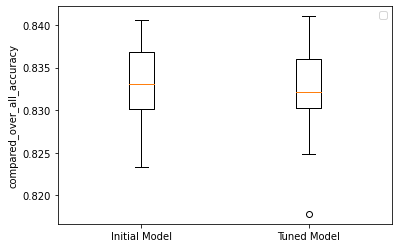

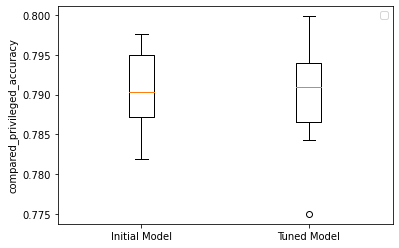

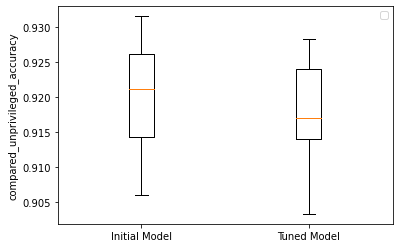

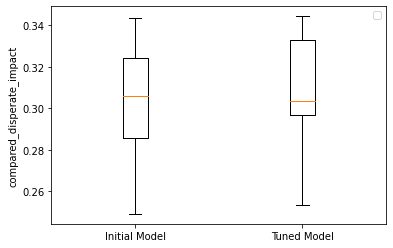

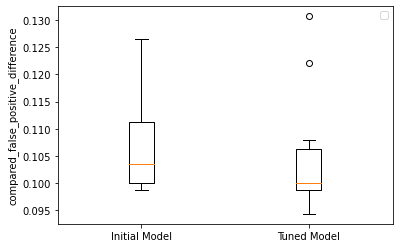

In [38]:
#Draw boxplot to understand the difference
init_metrics=[overall_accuracy_o_rf,privileged_accuracy_o_rf,unprivileged_accuracy_o_rf,disparate_impact_o_rf,false_positive_difference_o_rf]
tuned_metrics=[overall_accuracy_rf,privileged_accuracy_rf,unprivileged_accuracy_rf,disparate_impact_rf,false_positive_difference_rf]
#over all
metric_name="compared_over_all_accuracy"
plot_init_v_tuned_box(init_metrics[0], tuned_metrics[0], metric_name)

#privileged
metric_name="compared_privileged_accuracy"
plot_init_v_tuned_box(init_metrics[1], tuned_metrics[1], metric_name)


#unprivileged
metric_name="compared_unprivileged_accuracy"
plot_init_v_tuned_box(init_metrics[2], tuned_metrics[2], metric_name)

#disperate impact
metric_name="compared_disperate_impact"
plot_init_v_tuned_box(init_metrics[3], tuned_metrics[3], metric_name)

#false_positive rate difference
metric_name="compared_false_positive_difference"
plot_init_v_tuned_box(init_metrics[4], tuned_metrics[4], metric_name)


# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [39]:
#define the description matrice
def des_matrice(model,X, y_true):
  orig_pred=df_test.copy()
  orig_pred["income-per-year"]=model.predict(X)
  preds_aif360 = StandardDataset(orig_pred, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
  orig_aif360 = StandardDataset(df_test, label_name='income-per-year', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])
  
  #classifiacation Metric
  orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
  #BinaryMetric
  metric_dataset_predict = BinaryLabelDatasetMetric(
    preds_aif360, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )
  #accuracy
  accuracy=orig_vs_preds_metrics.accuracy()

  #accuracy for p-group and un-group
  privileged_accuracy=orig_vs_preds_metrics.accuracy(privileged=True)
  unprivileged_accuracy=orig_vs_preds_metrics.accuracy(privileged=False)

  #disparate impact
  disparate_impact=metric_dataset_predict.disparate_impact()

  #false positive rate difference
  FP_p=orig_vs_preds_metrics.false_positive_rate(privileged=True)
  FP_up=orig_vs_preds_metrics.false_positive_rate(privileged=False)
  fp_rate_d=abs(FP_p-FP_up)

  return accuracy,privileged_accuracy,unprivileged_accuracy,disparate_impact,fp_rate_d

In [40]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Takes a list of repair levels and another list of values of a metric and
  creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [41]:
#LR
#Split for 10 sample
#Use for loop to test on 10 difference model
#create list to store the tuned result
#create list to store the tuned result
all_split_list=[]
repaired_level=[0.2, 0.4, 0.6, 0.8, 1]


#start the for loop
for i in range (10):
  overall_accuracy=[]
  privileged_accuracy=[]
  unprivileged_accuracy=[]
  disparate_impact=[]
  false_positive_difference=[]  

  #splite the data
  single_protected = ['sex']
  single_privileged = [['Male']]
  ad = AdultDataset(protected_attribute_names=single_protected,
  privileged_classes=single_privileged, features_to_drop=['race',"age"])
  #split the original data to test and training group
  ad_train, ad_test = ad.split([0.8], shuffle=True)

  # Split training data in to training and validation data for hyperparameter tuning
  ad_train, ad_val = ad_train.split([0.875], shuffle=True)

  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]

  #Use MinMaxScaler to fit the test data and train data
  scaler = MinMaxScaler()
  ad_train.features=scaler.fit_transform(ad_train.features)
  ad_test.features=scaler.transform(ad_test.features)
  ad_val.features=scaler.transform(ad_val.features)
  
  #Repaired level
  for r in range(5):
    dis=DisparateImpactRemover(repair_level = repaired_level[r], sensitive_attribute = "sex")
    ad_train=dis.fit_transform(ad_train)
    ad_test=dis.fit_transform(ad_test)

    #transform the dataframe
    df,_= ad.convert_to_dataframe()
    df_test,_= ad_test.convert_to_dataframe()
    df_train,_= ad_train.convert_to_dataframe()
    df_val,_=ad_val.convert_to_dataframe()
    #seperate feasures and outcome
    x_train= df_train.drop("income-per-year", axis=1)
    y_train = df_train["income-per-year"]

    #best model list
    #match the best model given in part b
    best_model_lr=best_model_list[i]
    best_model_10 = best_model_lr.fit(x_train, y_train, sample_weight=None)

    # Before we call the function, we need to set up the test data properly, the way we did for the training data.
    x_test_10_best = df_test.drop("income-per-year", axis=1)
    y_test_10_best = df_test["income-per-year"]

    acc,p_acc,up_acc,dis_impact,fp_diff=des_matrice(best_model_10,x_test_10_best, y_test_10_best)

    overall_accuracy.append(acc)
    privileged_accuracy.append(p_acc)
    unprivileged_accuracy.append(up_acc)
    disparate_impact.append(dis_impact)
    false_positive_difference.append(fp_diff)

  metrics_split=[overall_accuracy,privileged_accuracy,unprivileged_accuracy,disparate_impact,false_positive_difference]
  #print("remover_metrics", "r=",repaired_level[r])
  #print(remover_metrics)
  all_split_list.append(metrics_split)


In [42]:
all_split_list

[[[0.8443338861249309,
   0.8449972360420122,
   0.8446655610834716,
   0.8440022111663903,
   0.843338861249309],
  [0.8070776255707762,
   0.8078930202217873,
   0.806914546640574,
   0.8059360730593608,
   0.8049575994781474],
  [0.9227600411946447,
   0.9231033299004463,
   0.924133196017851,
   0.924133196017851,
   0.924133196017851],
  [0.31635763064181494,
   0.31749114693670305,
   0.24158410275150582,
   0.2386235132570021,
   0.2365939086484978],
  [0.07683678754973114,
   0.07636686273770106,
   0.091872749221568,
   0.0949272604997635,
   0.09727688455991387]],
 [[0.8504145936981757,
   0.8490878938640133,
   0.8297401879491432,
   0.831951354339414,
   0.8313985627418463],
  [0.8138428735443661,
   0.8120387075610956,
   0.7833360669181565,
   0.786616368705921,
   0.7857962932589798],
  [0.9260515603799185,
   0.9257123473541384,
   0.9257123473541384,
   0.9257123473541384,
   0.9257123473541384],
  [0.3042993630573248,
   0.3070896179353249,
   0.18998608160574318,
   

In [43]:
#split the all_split_list
s1=all_split_list[0]
s2=all_split_list[1]
s3=all_split_list[2]
s4=all_split_list[3]
s5=all_split_list[4]
s6=all_split_list[5]
s7=all_split_list[6]
s8=all_split_list[7]
s9=all_split_list[8]
s10=all_split_list[9]

The graph for split one logistics regression


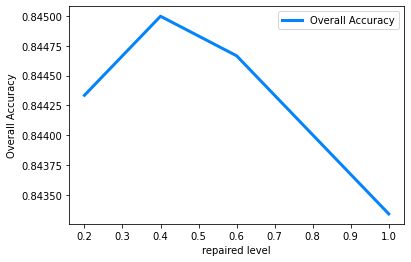

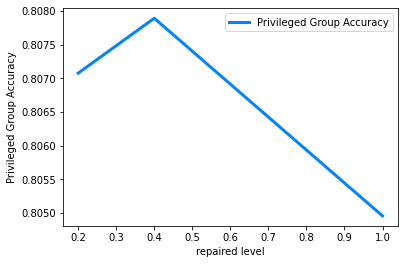

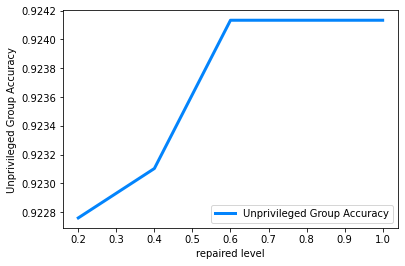

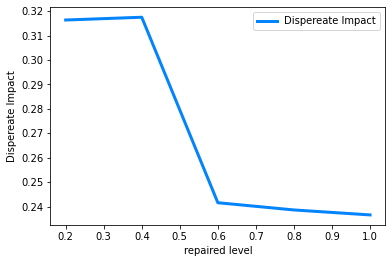

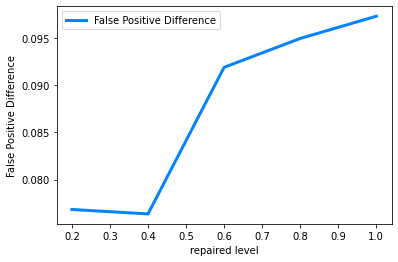

In [44]:
#seed one
print("The graph for split one logistics regression")
plot_repair_levels(repaired_level, s1[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s1[4], "False Positive Difference", x_label='repaired level')

The graph for split two logistics regression


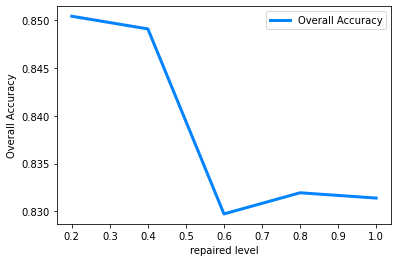

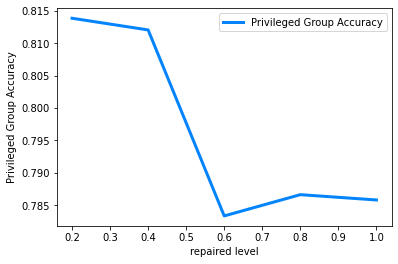

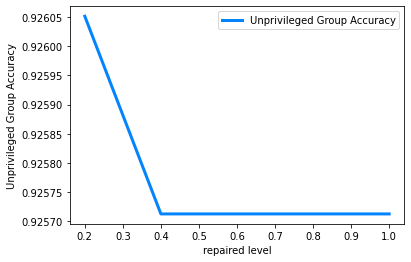

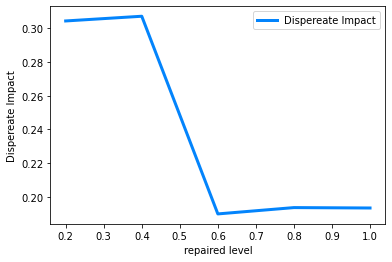

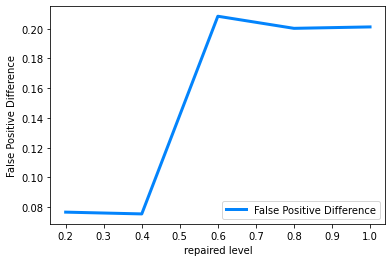

In [45]:
#seed two
print("The graph for split two logistics regression")
plot_repair_levels(repaired_level, s2[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s2[4], "False Positive Difference", x_label='repaired level')

The graph for split three logistics regression


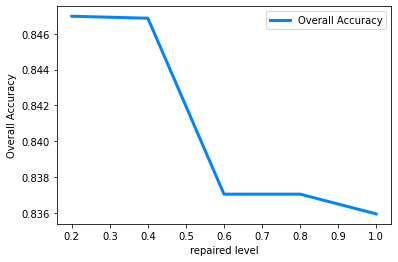

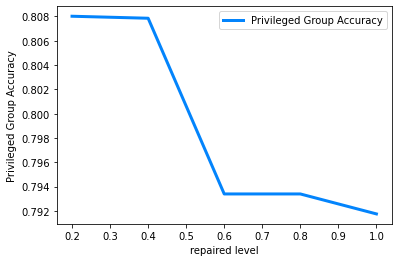

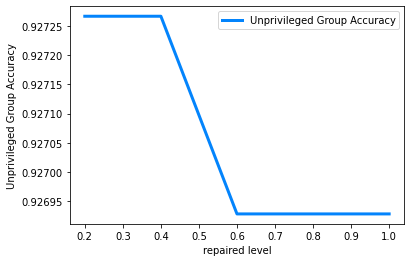

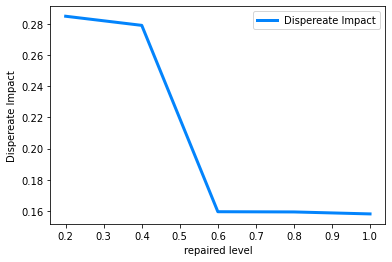

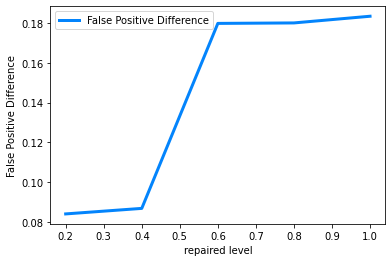

In [46]:
#seed three
print("The graph for split three logistics regression")
plot_repair_levels(repaired_level, s3[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s3[4], "False Positive Difference", x_label='repaired level')

The graph for split four logistics regression


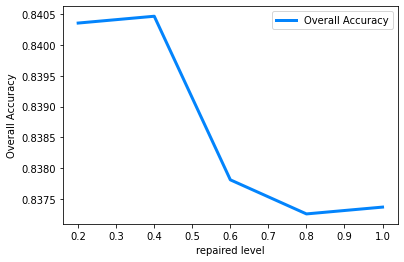

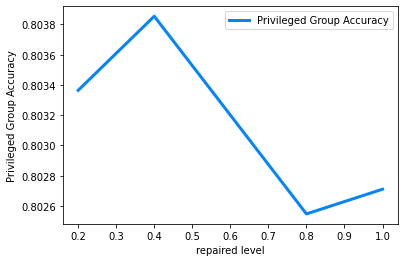

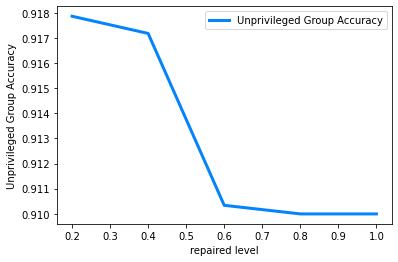

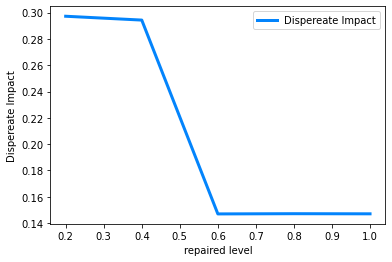

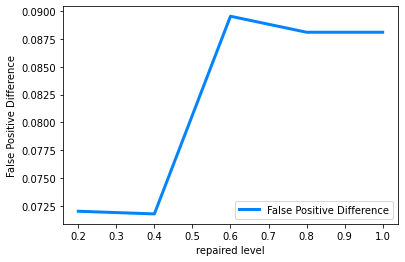

In [47]:
#seed four
print("The graph for split four logistics regression")
plot_repair_levels(repaired_level, s4[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s4[4], "False Positive Difference", x_label='repaired level')

The graph for split five logistics regression


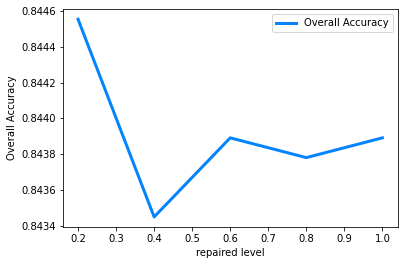

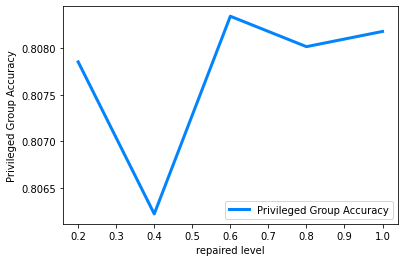

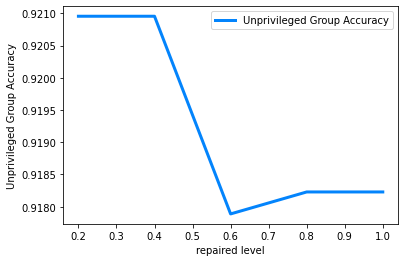

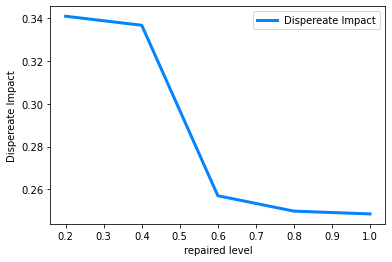

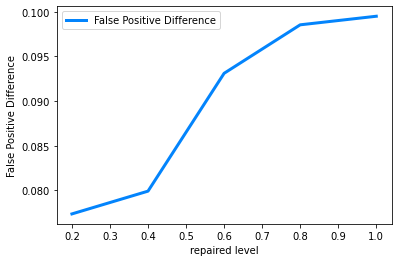

In [48]:
#seed five
print("The graph for split five logistics regression")
plot_repair_levels(repaired_level, s5[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s5[4], "False Positive Difference", x_label='repaired level')

In [49]:
#Split for 10 sample
#Use for loop to test on 10 difference model
#create list to store the tuned result
#create list to store the tuned result
all_split_list_2=[]
repaired_level=[0.2, 0.4, 0.6, 0.8, 1]


#start the for loop
for i in range (10):
  overall_accuracy=[]
  privileged_accuracy=[]
  unprivileged_accuracy=[]
  disparate_impact=[]
  false_positive_difference=[]  

  #splite the data
  single_protected = ['sex']
  single_privileged = [['Male']]
  ad = AdultDataset(protected_attribute_names=single_protected,
  privileged_classes=single_privileged, features_to_drop=['race',"age"])
  #split the original data to test and training group
  ad_train, ad_test = ad.split([0.8], shuffle=True)

  # Split training data in to training and validation data for hyperparameter tuning
  ad_train, ad_val = ad_train.split([0.875], shuffle=True)

  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]

  #Use MinMaxScaler to fit the test data and train data
  scaler = MinMaxScaler()
  ad_train.features=scaler.fit_transform(ad_train.features)
  ad_test.features=scaler.transform(ad_test.features)
  ad_val.features=scaler.transform(ad_val.features)
  
  #Repaired level
  for r in range(5):
    dis=DisparateImpactRemover(repair_level = repaired_level[r], sensitive_attribute = "sex")
    ad_train=dis.fit_transform(ad_train)
    ad_test=dis.fit_transform(ad_test)

    #transform the dataframe
    df,_= ad.convert_to_dataframe()
    df_test,_= ad_test.convert_to_dataframe()
    df_train,_= ad_train.convert_to_dataframe()
    df_val,_=ad_val.convert_to_dataframe()
    #seperate feasures and outcome
    x_train= df_train.drop("income-per-year", axis=1)
    y_train = df_train["income-per-year"]

    #best model list
    #match the best model given in part b
    best_model_rf=best_model_list_rf[i]
    best_model_10 = best_model_rf.fit(x_train, y_train, sample_weight=None)

    # Before we call the function, we need to set up the test data properly, the way we did for the training data.
    x_test_10_best = df_test.drop("income-per-year", axis=1)
    y_test_10_best = df_test["income-per-year"]

    acc,p_acc,up_acc,dis_impact,fp_diff=des_matrice(best_model_10,x_test_10_best, y_test_10_best)

    overall_accuracy.append(acc)
    privileged_accuracy.append(p_acc)
    unprivileged_accuracy.append(up_acc)
    disparate_impact.append(dis_impact)
    false_positive_difference.append(fp_diff)

  metrics_split_2=[overall_accuracy,privileged_accuracy,unprivileged_accuracy,disparate_impact,false_positive_difference]
  #print("remover_metrics", "r=",repaired_level[r])
  #print(remover_metrics)
  all_split_list_2.append(metrics_split_2)


In [50]:
#split the all_split_list
s1_rf=all_split_list_2[0]
s2_rf=all_split_list_2[1]
s3_rf=all_split_list_2[2]
s4_rf=all_split_list_2[3]
s5_rf=all_split_list_2[4]
s6_rf=all_split_list_2[5]
s7_rf=all_split_list_2[6]
s8_rf=all_split_list_2[7]
s9_rf=all_split_list_2[8]
s10_rf=all_split_list_2[9]

The graph for split one for random forest


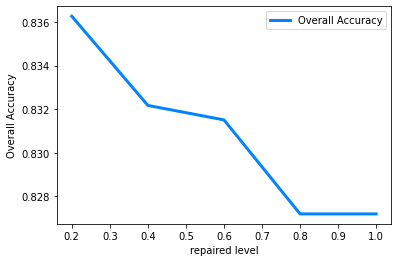

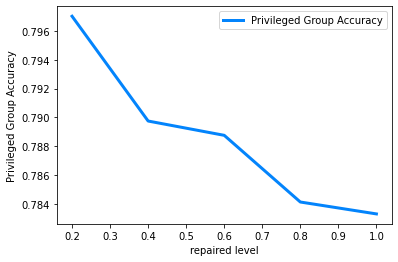

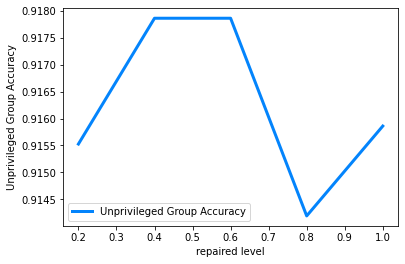

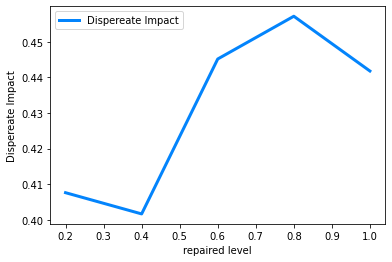

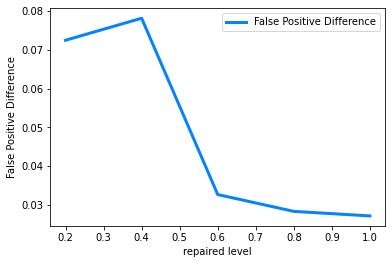

In [51]:
#seed one for random forest
print("The graph for split one for random forest")
plot_repair_levels(repaired_level, s1_rf[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1_rf[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1_rf[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s1_rf[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s1_rf[4], "False Positive Difference", x_label='repaired level')

The graph for split two for random forest


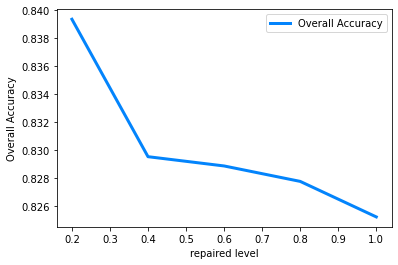

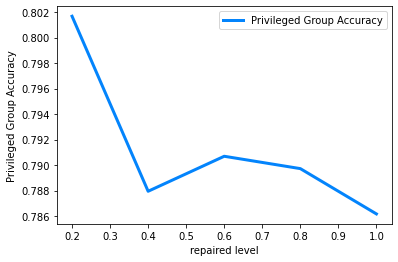

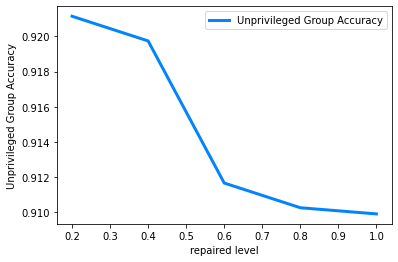

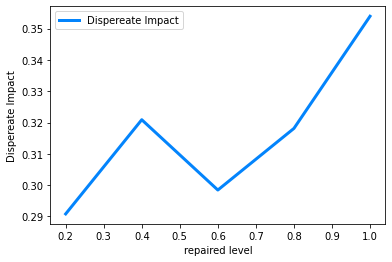

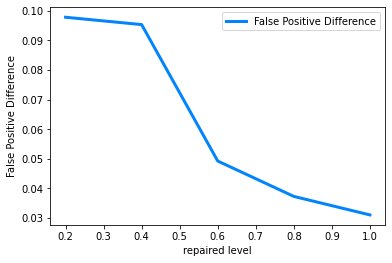

In [52]:
#seed two for random forest
print("The graph for split two for random forest")
plot_repair_levels(repaired_level, s2_rf[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2_rf[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2_rf[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s2_rf[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s2_rf[4], "False Positive Difference", x_label='repaired level')

The graph for split three for random forest


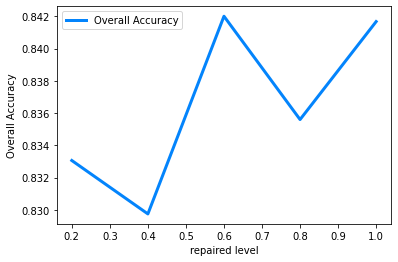

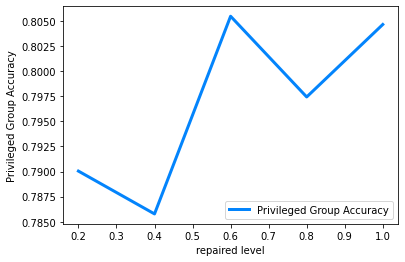

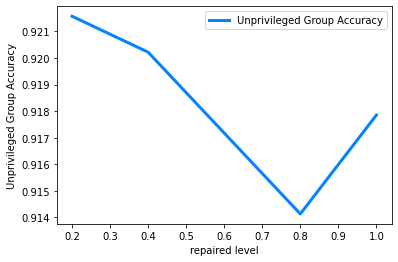

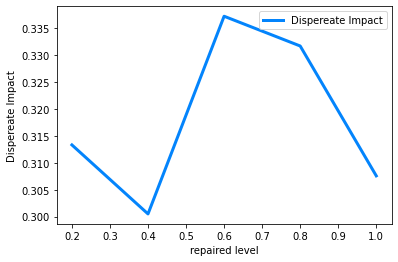

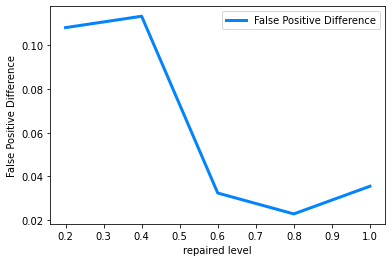

In [53]:
#seed three for random forest
print("The graph for split three for random forest")
plot_repair_levels(repaired_level, s3_rf[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3_rf[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3_rf[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s3_rf[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s3_rf[4], "False Positive Difference", x_label='repaired level')

The graph for split four for random forest


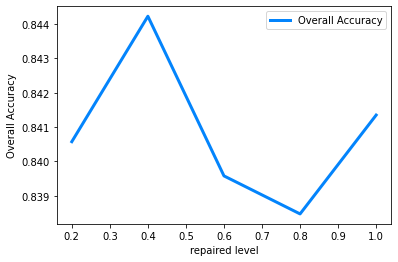

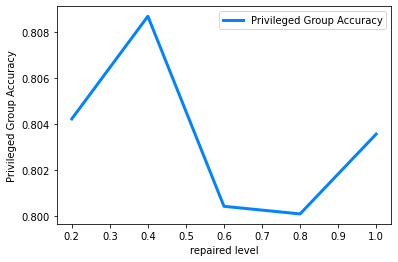

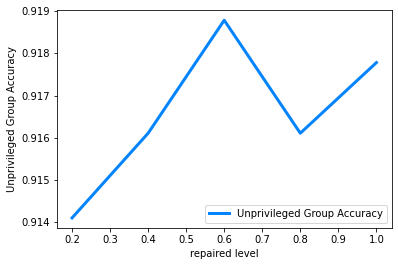

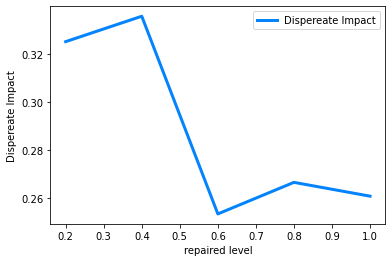

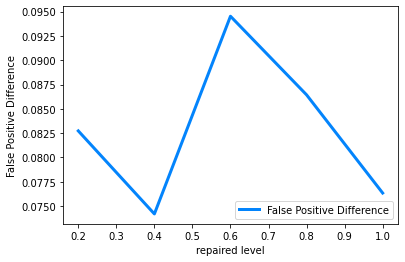

In [54]:
#seed four for random forest
print("The graph for split four for random forest")
plot_repair_levels(repaired_level, s4_rf[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4_rf[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4_rf[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s4_rf[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s4_rf[4], "False Positive Difference", x_label='repaired level')

The graph for split five for random forest


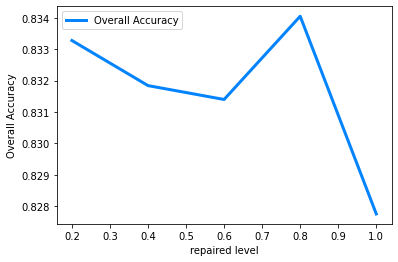

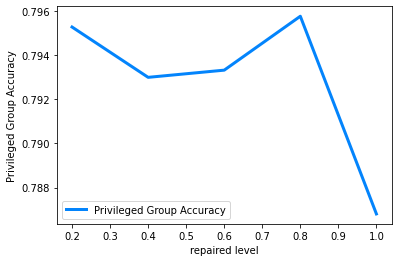

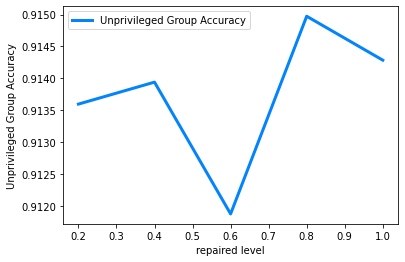

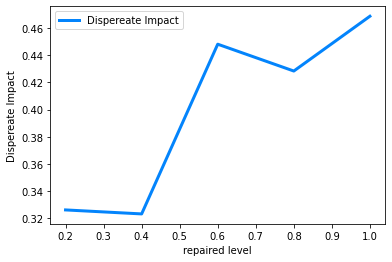

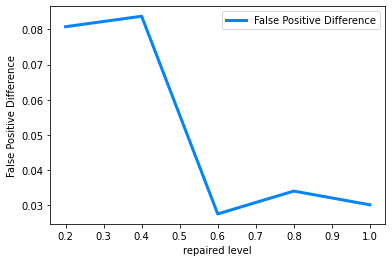

In [55]:
#seed five for random forest
print("The graph for split five for random forest")
plot_repair_levels(repaired_level, s5_rf[0], "Overall Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5_rf[1], "Privileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5_rf[2], "Unprivileged Group Accuracy", x_label='repaired level')
plot_repair_levels(repaired_level, s5_rf[3], "Dispereate Impact", x_label='repaired level')
plot_repair_levels(repaired_level, s5_rf[4], "False Positive Difference", x_label='repaired level')